# **Stock Price Prediction with Stacked LSTM**

**Project Overview:**
This project aims to predict the future stock prices of GOOGLE using stacked Long Short-Term Memory (LSTM), a type of recurrent neural network (RNN).

**>> Stock price data for Google (GOOGL) from Yahoo Finance. Used the pandas_datareader library to fetch historical stock price data for Google (GOOGL).**

**>> The data spans from January 1, 2018, to December 30, 2022, and it contains 1258 data points.**


Note:**The forecasting and predictions provided in this project are intended solely for educational and research purposes. The information and results generated by the models should not be considered as financial advice or used for making real-world financial decisions. The accuracy of the forecasts may vary, and they should be used with caution.**

In [1]:
!pip install pyforest
!pip install pandas_datareader

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14605 sha256=652f326d2e0e155fff1d7398f57f4bebfcc954a8994c66a0730900dfbe1d4650
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest


In [2]:
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import data as pdr
import datetime
import pyforest
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense, LSTM
yf.pdr_override()

**Data Selection and EDA**

In [3]:
ds_google=pdr.get_data_yahoo('GOOGL',start='2018-01-01',end='2022-12-30')


[*********************100%%**********************]  1 of 1 completed


In [4]:
ds_google

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2022-12-22,88.160004,88.540001,86.320000,87.760002,87.760002,27658300
2022-12-23,87.110001,89.550003,87.070000,89.230003,89.230003,23003000
2022-12-27,88.800003,88.940002,87.010002,87.389999,87.389999,20097300


In [5]:
ds_google.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-01-02 to 2022-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


In [6]:
data = ds_google[['Open','Close']]
data.head()

,Open,Close
Date,,
2018-01-02,52.651001,53.660500
2018-01-03,53.696499,54.576000
2018-01-04,54.854500,54.787998
2018-01-05,55.172501,55.514500
2018-01-08,55.549999,55.710499


<Axes: xlabel='Date'>

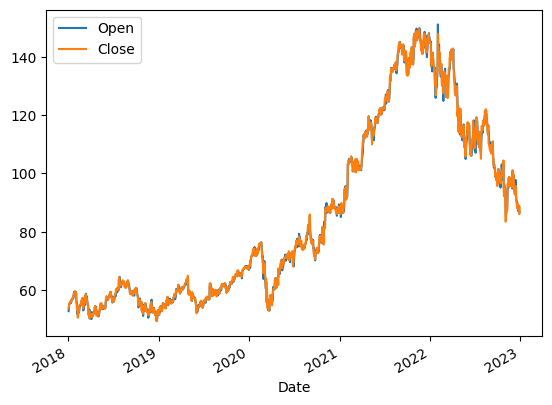

In [7]:
data.plot()

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'Close'}>]], dtype=object)

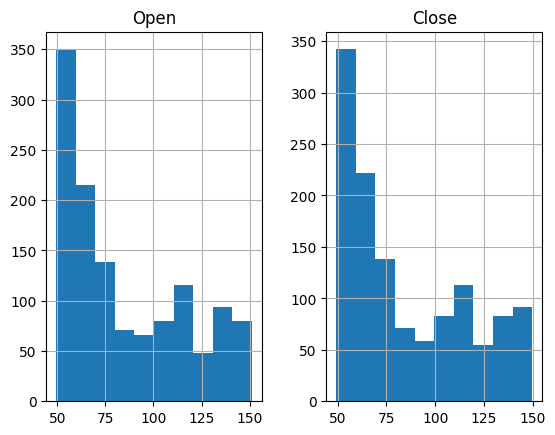

In [8]:
data.hist()

**Data Preprocessing - Extracting 'Close' Prices Indexing for Target Variable**

In [9]:
Index_data=data.reset_index()['Close']

<Axes: >

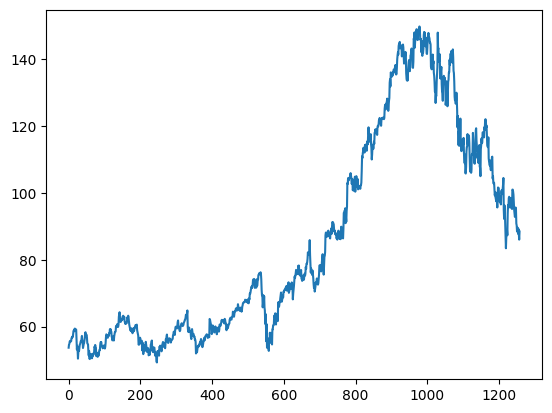

In [10]:
Index_data.plot()

**Scaling the Data** : Min-Max scaling to normalize the 'Close' prices. The scaling transforms the data so that all values fall within the range of 0 to 1.

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
Index_data=scaler.fit_transform(np.array(Index_data).reshape(-1,1))

<IPython.core.display.Javascript object>

In [12]:
Index_data

array([[0.04400376],
       [0.05310371],
       [0.05521094],
       ...,
       [0.3792704 ],
       [0.36565275],
       [0.38980663]])

**Training and Testing Sets**

In [13]:
#Spillting the Data into train and Test split

training_size=int(len(Index_data)*0.65)
test_size=len(Index_data)-training_size
train_data,test_data=Index_data[0:training_size,:],Index_data[training_size:len(Index_data),:1]

**Time Series Sequences &  Sequential Data**

In [14]:

def create_dataset(dataset,time_step=1):
  dataX,dataY =[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)


**Reshaping Data for LSTM**

In [15]:
#reshape into X=t,t+1,t+2,t+3 and Y=t+4

time_step=100
X_train,Y_train=create_dataset(train_data,time_step)
X_test,Y_test=create_dataset(test_data,time_step)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
print(X_train.shape), print(Y_train.shape)

(716, 100)
(716,)


(None, None)

In [17]:
print(X_test.shape),print(Y_test.shape)

(340, 100)
(340,)


(None, None)

In [18]:
#Reshape the Train_test data into 3D which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

***Model Building - Creating a Stacked LSTM Model***

In [19]:
 #Creating a Stacked LSTM Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Model Training - Training the Stacked LSTM Model**

In [21]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 15s 221ms/step - loss: 0.0148 - val_loss: 0.0799
Epoch 2/100
12/12 [==============================] - 0s 40ms/step - loss: 0.0047 - val_loss: 0.0168
Epoch 3/100
12/12 [==============================] - 0s 31ms/step - loss: 0.0016 - val_loss: 0.0138
Epoch 4/100
12/12 [==============================] - 0s 34ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 5/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 6/100
12/12 [==============================] - 0s 30ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 7/100
12/12 [==============================] - 0s 31ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 8/100
12/12 [==============================] - 0s 31ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 9/100
12/12 [==============================] - 0s 41ms/step - loss: 9.9953e-04 - val_loss: 0.0033
Epoch 10/100
12/12 [==============================] - 0s 42ms/step - loss: 9.3892e-04 - val_lo

**Prediction and Performance Evaluation**

In [22]:
import tensorflow as tf

#Prediction and Performance

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 8ms/step


In [23]:
#Transform to Original form REVERSE SCALING

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [24]:
#Calculated the RMSE performance Metrics

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

68.4295873861635

In [25]:
#For test data

math.sqrt(mean_squared_error(Y_test,test_predict))

123.65322460406195

**Inverse Scaling - Transforming Predictions to Original Form**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

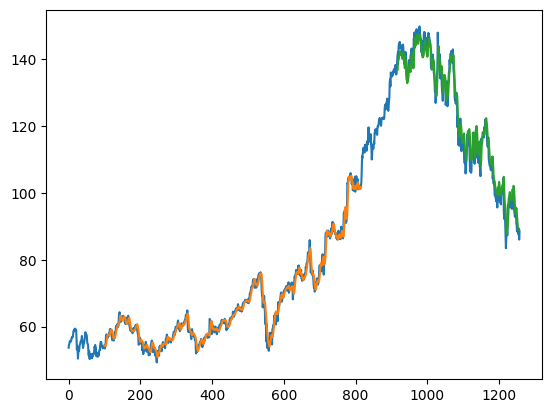

In [26]:
#Train prediction for plotting

# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(Index_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(Index_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(Index_data)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(Index_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()



In [27]:
len(test_data)

441

In [28]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [29]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [30]:
temp_input

[0.6699119936956728,
 0.7004273727403829,
 0.6918790837461515,
 0.72010833656865,
 0.7240842972833159,
 0.720307100478569,
 0.6989364538281333,
 0.7050991208924795,
 0.6756771329401812,
 0.6461557251153518,
 0.642378604145748,
 0.6406888454884365,
 0.6701108334407349,
 0.6073902408588603,
 0.598245584299729,
 0.5934744921102444,
 0.5863177779908746,
 0.6014263377044331,
 0.5826400010586585,
 0.5723025335345846,
 0.5985437680821788,
 0.587908116775655,
 0.6104716502261764,
 0.6125590125384688,
 0.5475522937343829,
 0.554311404198772,
 0.5335371251132361,
 0.5324437340208243,
 0.5351274638980166,
 0.5159435235972611,
 0.49745537073393664,
 0.5060036597281682,
 0.49208783514440924,
 0.4864221157724319,
 0.4797624251805739,
 0.5051091083808185,
 0.47896721787061214,
 0.4613736921897803,
 0.4910938639245286,
 0.5209134555318078,
 0.5188260932195154,
 0.5187266733469844,
 0.49149146757950946,
 0.4833407822402588,
 0.47658167177586985,
 0.48035879274547366,
 0.49526858854911326,
 0.4704189288

**Forecasting for future 30 Days.**

In [31]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


# print(lst_output)

[0.38668048]
101


<IPython.core.display.Javascript object>

1 day input [0.70042737 0.69187908 0.72010834 0.7240843  0.7203071  0.69893645
 0.70509912 0.67567713 0.64615573 0.6423786  0.64068885 0.67011083
 0.60739024 0.59824558 0.59347449 0.58631778 0.60142634 0.58264
 0.57230253 0.59854377 0.58790812 0.61047165 0.61255901 0.54755229
 0.5543114  0.53353713 0.53244373 0.53512746 0.51594352 0.49745537
 0.50600366 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722
 0.46137369 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147
 0.48334078 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139
 0.51226575 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271
 0.45421698 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567
 0.33990854 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653
 0.46892801 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664
 0.46087667 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136
 0.51445253 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164
 0.44209033 0.43334328 0.43811437 0.46117485 0.45560855

<IPython.core.display.Javascript object>

2 day input [0.69187908 0.72010834 0.7240843  0.7203071  0.69893645 0.70509912
 0.67567713 0.64615573 0.6423786  0.64068885 0.67011083 0.60739024
 0.59824558 0.59347449 0.58631778 0.60142634 0.58264    0.57230253
 0.59854377 0.58790812 0.61047165 0.61255901 0.54755229 0.5543114
 0.53353713 0.53244373 0.53512746 0.51594352 0.49745537 0.50600366
 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369
 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078
 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575
 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698
 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854
 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801
 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667
 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253
 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033
 0.43334328 0.43811437 0.46117485 0.45560855 0.4137

<IPython.core.display.Javascript object>

3 day input [0.72010834 0.7240843  0.7203071  0.69893645 0.70509912 0.67567713
 0.64615573 0.6423786  0.64068885 0.67011083 0.60739024 0.59824558
 0.59347449 0.58631778 0.60142634 0.58264    0.57230253 0.59854377
 0.58790812 0.61047165 0.61255901 0.54755229 0.5543114  0.53353713
 0.53244373 0.53512746 0.51594352 0.49745537 0.50600366 0.49208784
 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386
 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167
 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431
 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698 0.42727996
 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854 0.37121913
 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064
 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952
 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253
 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328
 0.43811437 0.46117485 0.45560855 0.41376174 0.407

<IPython.core.display.Javascript object>

4 day input [0.7240843  0.7203071  0.69893645 0.70509912 0.67567713 0.64615573
 0.6423786  0.64068885 0.67011083 0.60739024 0.59824558 0.59347449
 0.58631778 0.60142634 0.58264    0.57230253 0.59854377 0.58790812
 0.61047165 0.61255901 0.54755229 0.5543114  0.53353713 0.53244373
 0.53512746 0.51594352 0.49745537 0.50600366 0.49208784 0.48642212
 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346
 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879
 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139
 0.5158441  0.52966051 0.54914271 0.45421698 0.42727996 0.4677352
 0.45004225 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423
 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592
 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469
 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565
 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437
 0.46117485 0.45560855 0.41376174 0.40779783 0.38970

<IPython.core.display.Javascript object>

5 day input [0.7203071  0.69893645 0.70509912 0.67567713 0.64615573 0.6423786
 0.64068885 0.67011083 0.60739024 0.59824558 0.59347449 0.58631778
 0.60142634 0.58264    0.57230253 0.59854377 0.58790812 0.61047165
 0.61255901 0.54755229 0.5543114  0.53353713 0.53244373 0.53512746
 0.51594352 0.49745537 0.50600366 0.49208784 0.48642212 0.47976243
 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346 0.51882609
 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879 0.49526859
 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139  0.5158441
 0.52966051 0.54914271 0.45421698 0.42727996 0.4677352  0.45004225
 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423 0.39427961
 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592 0.49318123
 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469 0.47936482
 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565 0.49944339
 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437 0.46117485
 0.45560855 0.41376174 0.40779783 0.38970728 0.39547

<IPython.core.display.Javascript object>

6 day input [0.69893645 0.70509912 0.67567713 0.64615573 0.6423786  0.64068885
 0.67011083 0.60739024 0.59824558 0.59347449 0.58631778 0.60142634
 0.58264    0.57230253 0.59854377 0.58790812 0.61047165 0.61255901
 0.54755229 0.5543114  0.53353713 0.53244373 0.53512746 0.51594352
 0.49745537 0.50600366 0.49208784 0.48642212 0.47976243 0.50510911
 0.47896722 0.46137369 0.49109386 0.52091346 0.51882609 0.51872667
 0.49149147 0.48334078 0.47658167 0.48035879 0.49526859 0.47041893
 0.5043139  0.51226575 0.50093431 0.5043139  0.5158441  0.52966051
 0.54914271 0.45421698 0.42727996 0.4677352  0.45004225 0.40988519
 0.37509567 0.33990854 0.37121913 0.39020423 0.39427961 0.37857461
 0.44437653 0.46892801 0.46187064 0.48910592 0.49318123 0.48831071
 0.47906664 0.46087667 0.47528952 0.48930469 0.47936482 0.46534965
 0.45680136 0.51445253 0.51445253 0.50898565 0.49944339 0.47459373
 0.4543164  0.44209033 0.43334328 0.43811437 0.46117485 0.45560855
 0.41376174 0.40779783 0.38970728 0.39547235 0.401

<IPython.core.display.Javascript object>

7 day input [0.70509912 0.67567713 0.64615573 0.6423786  0.64068885 0.67011083
 0.60739024 0.59824558 0.59347449 0.58631778 0.60142634 0.58264
 0.57230253 0.59854377 0.58790812 0.61047165 0.61255901 0.54755229
 0.5543114  0.53353713 0.53244373 0.53512746 0.51594352 0.49745537
 0.50600366 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722
 0.46137369 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147
 0.48334078 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139
 0.51226575 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271
 0.45421698 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567
 0.33990854 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653
 0.46892801 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664
 0.46087667 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136
 0.51445253 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164
 0.44209033 0.43334328 0.43811437 0.46117485 0.45560855 0.41376174
 0.40779783 0.38970728 0.39547235 0.40103872 0.38294817

<IPython.core.display.Javascript object>

8 day input [0.67567713 0.64615573 0.6423786  0.64068885 0.67011083 0.60739024
 0.59824558 0.59347449 0.58631778 0.60142634 0.58264    0.57230253
 0.59854377 0.58790812 0.61047165 0.61255901 0.54755229 0.5543114
 0.53353713 0.53244373 0.53512746 0.51594352 0.49745537 0.50600366
 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369
 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078
 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575
 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698
 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854
 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801
 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667
 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253
 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033
 0.43334328 0.43811437 0.46117485 0.45560855 0.41376174 0.40779783
 0.38970728 0.39547235 0.40103872 0.38294817 0.3975

<IPython.core.display.Javascript object>

9 day input [0.64615573 0.6423786  0.64068885 0.67011083 0.60739024 0.59824558
 0.59347449 0.58631778 0.60142634 0.58264    0.57230253 0.59854377
 0.58790812 0.61047165 0.61255901 0.54755229 0.5543114  0.53353713
 0.53244373 0.53512746 0.51594352 0.49745537 0.50600366 0.49208784
 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386
 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167
 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431
 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698 0.42727996
 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854 0.37121913
 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064
 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952
 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253
 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328
 0.43811437 0.46117485 0.45560855 0.41376174 0.40779783 0.38970728
 0.39547235 0.40103872 0.38294817 0.39755978 0.379

<IPython.core.display.Javascript object>

10 day input [0.6423786  0.64068885 0.67011083 0.60739024 0.59824558 0.59347449
 0.58631778 0.60142634 0.58264    0.57230253 0.59854377 0.58790812
 0.61047165 0.61255901 0.54755229 0.5543114  0.53353713 0.53244373
 0.53512746 0.51594352 0.49745537 0.50600366 0.49208784 0.48642212
 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346
 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879
 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139
 0.5158441  0.52966051 0.54914271 0.45421698 0.42727996 0.4677352
 0.45004225 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423
 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592
 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469
 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565
 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437
 0.46117485 0.45560855 0.41376174 0.40779783 0.38970728 0.39547235
 0.40103872 0.38294817 0.39755978 0.3792704  0.3656

<IPython.core.display.Javascript object>

11 day input [0.64068885 0.67011083 0.60739024 0.59824558 0.59347449 0.58631778
 0.60142634 0.58264    0.57230253 0.59854377 0.58790812 0.61047165
 0.61255901 0.54755229 0.5543114  0.53353713 0.53244373 0.53512746
 0.51594352 0.49745537 0.50600366 0.49208784 0.48642212 0.47976243
 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346 0.51882609
 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879 0.49526859
 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139  0.5158441
 0.52966051 0.54914271 0.45421698 0.42727996 0.4677352  0.45004225
 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423 0.39427961
 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592 0.49318123
 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469 0.47936482
 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565 0.49944339
 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437 0.46117485
 0.45560855 0.41376174 0.40779783 0.38970728 0.39547235 0.40103872
 0.38294817 0.39755978 0.3792704  0.36565275 0.389

<IPython.core.display.Javascript object>

12 day input [0.67011083 0.60739024 0.59824558 0.59347449 0.58631778 0.60142634
 0.58264    0.57230253 0.59854377 0.58790812 0.61047165 0.61255901
 0.54755229 0.5543114  0.53353713 0.53244373 0.53512746 0.51594352
 0.49745537 0.50600366 0.49208784 0.48642212 0.47976243 0.50510911
 0.47896722 0.46137369 0.49109386 0.52091346 0.51882609 0.51872667
 0.49149147 0.48334078 0.47658167 0.48035879 0.49526859 0.47041893
 0.5043139  0.51226575 0.50093431 0.5043139  0.5158441  0.52966051
 0.54914271 0.45421698 0.42727996 0.4677352  0.45004225 0.40988519
 0.37509567 0.33990854 0.37121913 0.39020423 0.39427961 0.37857461
 0.44437653 0.46892801 0.46187064 0.48910592 0.49318123 0.48831071
 0.47906664 0.46087667 0.47528952 0.48930469 0.47936482 0.46534965
 0.45680136 0.51445253 0.51445253 0.50898565 0.49944339 0.47459373
 0.4543164  0.44209033 0.43334328 0.43811437 0.46117485 0.45560855
 0.41376174 0.40779783 0.38970728 0.39547235 0.40103872 0.38294817
 0.39755978 0.3792704  0.36565275 0.38980663 0.38

<IPython.core.display.Javascript object>

13 day input [0.60739024 0.59824558 0.59347449 0.58631778 0.60142634 0.58264
 0.57230253 0.59854377 0.58790812 0.61047165 0.61255901 0.54755229
 0.5543114  0.53353713 0.53244373 0.53512746 0.51594352 0.49745537
 0.50600366 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722
 0.46137369 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147
 0.48334078 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139
 0.51226575 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271
 0.45421698 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567
 0.33990854 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653
 0.46892801 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664
 0.46087667 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136
 0.51445253 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164
 0.44209033 0.43334328 0.43811437 0.46117485 0.45560855 0.41376174
 0.40779783 0.38970728 0.39547235 0.40103872 0.38294817 0.39755978
 0.3792704  0.36565275 0.38980663 0.38668048 0.3891709

<IPython.core.display.Javascript object>

14 day input [0.59824558 0.59347449 0.58631778 0.60142634 0.58264    0.57230253
 0.59854377 0.58790812 0.61047165 0.61255901 0.54755229 0.5543114
 0.53353713 0.53244373 0.53512746 0.51594352 0.49745537 0.50600366
 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369
 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078
 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575
 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698
 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854
 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801
 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667
 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253
 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033
 0.43334328 0.43811437 0.46117485 0.45560855 0.41376174 0.40779783
 0.38970728 0.39547235 0.40103872 0.38294817 0.39755978 0.3792704
 0.36565275 0.38980663 0.38668048 0.38917094 0.3929

<IPython.core.display.Javascript object>

15 day input [0.59347449 0.58631778 0.60142634 0.58264    0.57230253 0.59854377
 0.58790812 0.61047165 0.61255901 0.54755229 0.5543114  0.53353713
 0.53244373 0.53512746 0.51594352 0.49745537 0.50600366 0.49208784
 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386
 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167
 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431
 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698 0.42727996
 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854 0.37121913
 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064
 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952
 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253
 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328
 0.43811437 0.46117485 0.45560855 0.41376174 0.40779783 0.38970728
 0.39547235 0.40103872 0.38294817 0.39755978 0.3792704  0.36565275
 0.38980663 0.38668048 0.38917094 0.39290324 0.39

<IPython.core.display.Javascript object>

16 day input [0.58631778 0.60142634 0.58264    0.57230253 0.59854377 0.58790812
 0.61047165 0.61255901 0.54755229 0.5543114  0.53353713 0.53244373
 0.53512746 0.51594352 0.49745537 0.50600366 0.49208784 0.48642212
 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346
 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879
 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139
 0.5158441  0.52966051 0.54914271 0.45421698 0.42727996 0.4677352
 0.45004225 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423
 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592
 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469
 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565
 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437
 0.46117485 0.45560855 0.41376174 0.40779783 0.38970728 0.39547235
 0.40103872 0.38294817 0.39755978 0.3792704  0.36565275 0.38980663
 0.38668048 0.38917094 0.39290324 0.39709044 0.4014

<IPython.core.display.Javascript object>

17 day input [0.60142634 0.58264    0.57230253 0.59854377 0.58790812 0.61047165
 0.61255901 0.54755229 0.5543114  0.53353713 0.53244373 0.53512746
 0.51594352 0.49745537 0.50600366 0.49208784 0.48642212 0.47976243
 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346 0.51882609
 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879 0.49526859
 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139  0.5158441
 0.52966051 0.54914271 0.45421698 0.42727996 0.4677352  0.45004225
 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423 0.39427961
 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592 0.49318123
 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469 0.47936482
 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565 0.49944339
 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437 0.46117485
 0.45560855 0.41376174 0.40779783 0.38970728 0.39547235 0.40103872
 0.38294817 0.39755978 0.3792704  0.36565275 0.38980663 0.38668048
 0.38917094 0.39290324 0.39709044 0.40149763 0.406

<IPython.core.display.Javascript object>

18 day input [0.58264    0.57230253 0.59854377 0.58790812 0.61047165 0.61255901
 0.54755229 0.5543114  0.53353713 0.53244373 0.53512746 0.51594352
 0.49745537 0.50600366 0.49208784 0.48642212 0.47976243 0.50510911
 0.47896722 0.46137369 0.49109386 0.52091346 0.51882609 0.51872667
 0.49149147 0.48334078 0.47658167 0.48035879 0.49526859 0.47041893
 0.5043139  0.51226575 0.50093431 0.5043139  0.5158441  0.52966051
 0.54914271 0.45421698 0.42727996 0.4677352  0.45004225 0.40988519
 0.37509567 0.33990854 0.37121913 0.39020423 0.39427961 0.37857461
 0.44437653 0.46892801 0.46187064 0.48910592 0.49318123 0.48831071
 0.47906664 0.46087667 0.47528952 0.48930469 0.47936482 0.46534965
 0.45680136 0.51445253 0.51445253 0.50898565 0.49944339 0.47459373
 0.4543164  0.44209033 0.43334328 0.43811437 0.46117485 0.45560855
 0.41376174 0.40779783 0.38970728 0.39547235 0.40103872 0.38294817
 0.39755978 0.3792704  0.36565275 0.38980663 0.38668048 0.38917094
 0.39290324 0.39709044 0.40149763 0.40607134 0.41

<IPython.core.display.Javascript object>

19 day input [0.57230253 0.59854377 0.58790812 0.61047165 0.61255901 0.54755229
 0.5543114  0.53353713 0.53244373 0.53512746 0.51594352 0.49745537
 0.50600366 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722
 0.46137369 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147
 0.48334078 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139
 0.51226575 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271
 0.45421698 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567
 0.33990854 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653
 0.46892801 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664
 0.46087667 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136
 0.51445253 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164
 0.44209033 0.43334328 0.43811437 0.46117485 0.45560855 0.41376174
 0.40779783 0.38970728 0.39547235 0.40103872 0.38294817 0.39755978
 0.3792704  0.36565275 0.38980663 0.38668048 0.38917094 0.39290324
 0.39709044 0.40149763 0.40607134 0.41080466 0.4157

<IPython.core.display.Javascript object>

20 day input [0.59854377 0.58790812 0.61047165 0.61255901 0.54755229 0.5543114
 0.53353713 0.53244373 0.53512746 0.51594352 0.49745537 0.50600366
 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369
 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078
 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575
 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698
 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854
 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801
 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667
 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253
 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033
 0.43334328 0.43811437 0.46117485 0.45560855 0.41376174 0.40779783
 0.38970728 0.39547235 0.40103872 0.38294817 0.39755978 0.3792704
 0.36565275 0.38980663 0.38668048 0.38917094 0.39290324 0.39709044
 0.40149763 0.40607134 0.41080466 0.41570479 0.4207

<IPython.core.display.Javascript object>

21 day input [0.58790812 0.61047165 0.61255901 0.54755229 0.5543114  0.53353713
 0.53244373 0.53512746 0.51594352 0.49745537 0.50600366 0.49208784
 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386
 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167
 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431
 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698 0.42727996
 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854 0.37121913
 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064
 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952
 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253
 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328
 0.43811437 0.46117485 0.45560855 0.41376174 0.40779783 0.38970728
 0.39547235 0.40103872 0.38294817 0.39755978 0.3792704  0.36565275
 0.38980663 0.38668048 0.38917094 0.39290324 0.39709044 0.40149763
 0.40607134 0.41080466 0.41570479 0.42078021 0.42

<IPython.core.display.Javascript object>

22 day input [0.61047165 0.61255901 0.54755229 0.5543114  0.53353713 0.53244373
 0.53512746 0.51594352 0.49745537 0.50600366 0.49208784 0.48642212
 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346
 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879
 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139
 0.5158441  0.52966051 0.54914271 0.45421698 0.42727996 0.4677352
 0.45004225 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423
 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592
 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469
 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565
 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437
 0.46117485 0.45560855 0.41376174 0.40779783 0.38970728 0.39547235
 0.40103872 0.38294817 0.39755978 0.3792704  0.36565275 0.38980663
 0.38668048 0.38917094 0.39290324 0.39709044 0.40149763 0.40607134
 0.41080466 0.41570479 0.42078021 0.42604136 0.4314

<IPython.core.display.Javascript object>

23 day input [0.61255901 0.54755229 0.5543114  0.53353713 0.53244373 0.53512746
 0.51594352 0.49745537 0.50600366 0.49208784 0.48642212 0.47976243
 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346 0.51882609
 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879 0.49526859
 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139  0.5158441
 0.52966051 0.54914271 0.45421698 0.42727996 0.4677352  0.45004225
 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423 0.39427961
 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592 0.49318123
 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469 0.47936482
 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565 0.49944339
 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437 0.46117485
 0.45560855 0.41376174 0.40779783 0.38970728 0.39547235 0.40103872
 0.38294817 0.39755978 0.3792704  0.36565275 0.38980663 0.38668048
 0.38917094 0.39290324 0.39709044 0.40149763 0.40607134 0.41080466
 0.41570479 0.42078021 0.42604136 0.43148935 0.437

<IPython.core.display.Javascript object>

24 day input [0.54755229 0.5543114  0.53353713 0.53244373 0.53512746 0.51594352
 0.49745537 0.50600366 0.49208784 0.48642212 0.47976243 0.50510911
 0.47896722 0.46137369 0.49109386 0.52091346 0.51882609 0.51872667
 0.49149147 0.48334078 0.47658167 0.48035879 0.49526859 0.47041893
 0.5043139  0.51226575 0.50093431 0.5043139  0.5158441  0.52966051
 0.54914271 0.45421698 0.42727996 0.4677352  0.45004225 0.40988519
 0.37509567 0.33990854 0.37121913 0.39020423 0.39427961 0.37857461
 0.44437653 0.46892801 0.46187064 0.48910592 0.49318123 0.48831071
 0.47906664 0.46087667 0.47528952 0.48930469 0.47936482 0.46534965
 0.45680136 0.51445253 0.51445253 0.50898565 0.49944339 0.47459373
 0.4543164  0.44209033 0.43334328 0.43811437 0.46117485 0.45560855
 0.41376174 0.40779783 0.38970728 0.39547235 0.40103872 0.38294817
 0.39755978 0.3792704  0.36565275 0.38980663 0.38668048 0.38917094
 0.39290324 0.39709044 0.40149763 0.40607134 0.41080466 0.41570479
 0.42078021 0.42604136 0.43148935 0.43711326 0.44

<IPython.core.display.Javascript object>

25 day input [0.5543114  0.53353713 0.53244373 0.53512746 0.51594352 0.49745537
 0.50600366 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722
 0.46137369 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147
 0.48334078 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139
 0.51226575 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271
 0.45421698 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567
 0.33990854 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653
 0.46892801 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664
 0.46087667 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136
 0.51445253 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164
 0.44209033 0.43334328 0.43811437 0.46117485 0.45560855 0.41376174
 0.40779783 0.38970728 0.39547235 0.40103872 0.38294817 0.39755978
 0.3792704  0.36565275 0.38980663 0.38668048 0.38917094 0.39290324
 0.39709044 0.40149763 0.40607134 0.41080466 0.41570479 0.42078021
 0.42604136 0.43148935 0.43711326 0.44289109 0.4487

<IPython.core.display.Javascript object>

26 day input [0.53353713 0.53244373 0.53512746 0.51594352 0.49745537 0.50600366
 0.49208784 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369
 0.49109386 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078
 0.47658167 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575
 0.50093431 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698
 0.42727996 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854
 0.37121913 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801
 0.46187064 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667
 0.47528952 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253
 0.51445253 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033
 0.43334328 0.43811437 0.46117485 0.45560855 0.41376174 0.40779783
 0.38970728 0.39547235 0.40103872 0.38294817 0.39755978 0.3792704
 0.36565275 0.38980663 0.38668048 0.38917094 0.39290324 0.39709044
 0.40149763 0.40607134 0.41080466 0.41570479 0.42078021 0.42604136
 0.43148935 0.43711326 0.44289109 0.44878677 0.454

<IPython.core.display.Javascript object>

27 day input [0.53244373 0.53512746 0.51594352 0.49745537 0.50600366 0.49208784
 0.48642212 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386
 0.52091346 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167
 0.48035879 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431
 0.5043139  0.5158441  0.52966051 0.54914271 0.45421698 0.42727996
 0.4677352  0.45004225 0.40988519 0.37509567 0.33990854 0.37121913
 0.39020423 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064
 0.48910592 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952
 0.48930469 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253
 0.50898565 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328
 0.43811437 0.46117485 0.45560855 0.41376174 0.40779783 0.38970728
 0.39547235 0.40103872 0.38294817 0.39755978 0.3792704  0.36565275
 0.38980663 0.38668048 0.38917094 0.39290324 0.39709044 0.40149763
 0.40607134 0.41080466 0.41570479 0.42078021 0.42604136 0.43148935
 0.43711326 0.44289109 0.44878677 0.454761   0.46

<IPython.core.display.Javascript object>

28 day input [0.53512746 0.51594352 0.49745537 0.50600366 0.49208784 0.48642212
 0.47976243 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346
 0.51882609 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879
 0.49526859 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139
 0.5158441  0.52966051 0.54914271 0.45421698 0.42727996 0.4677352
 0.45004225 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423
 0.39427961 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592
 0.49318123 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469
 0.47936482 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565
 0.49944339 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437
 0.46117485 0.45560855 0.41376174 0.40779783 0.38970728 0.39547235
 0.40103872 0.38294817 0.39755978 0.3792704  0.36565275 0.38980663
 0.38668048 0.38917094 0.39290324 0.39709044 0.40149763 0.40607134
 0.41080466 0.41570479 0.42078021 0.42604136 0.43148935 0.43711326
 0.44289109 0.44878677 0.454761   0.46075842 0.4667

<IPython.core.display.Javascript object>

29 day input [0.51594352 0.49745537 0.50600366 0.49208784 0.48642212 0.47976243
 0.50510911 0.47896722 0.46137369 0.49109386 0.52091346 0.51882609
 0.51872667 0.49149147 0.48334078 0.47658167 0.48035879 0.49526859
 0.47041893 0.5043139  0.51226575 0.50093431 0.5043139  0.5158441
 0.52966051 0.54914271 0.45421698 0.42727996 0.4677352  0.45004225
 0.40988519 0.37509567 0.33990854 0.37121913 0.39020423 0.39427961
 0.37857461 0.44437653 0.46892801 0.46187064 0.48910592 0.49318123
 0.48831071 0.47906664 0.46087667 0.47528952 0.48930469 0.47936482
 0.46534965 0.45680136 0.51445253 0.51445253 0.50898565 0.49944339
 0.47459373 0.4543164  0.44209033 0.43334328 0.43811437 0.46117485
 0.45560855 0.41376174 0.40779783 0.38970728 0.39547235 0.40103872
 0.38294817 0.39755978 0.3792704  0.36565275 0.38980663 0.38668048
 0.38917094 0.39290324 0.39709044 0.40149763 0.40607134 0.41080466
 0.41570479 0.42078021 0.42604136 0.43148935 0.43711326 0.44289109
 0.44878677 0.454761   0.46075842 0.4667224  0.472

In [32]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Future Forecasting**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

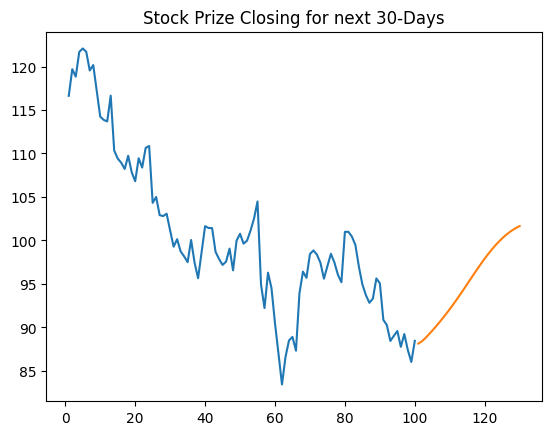

In [33]:

plt.title("Stock Prize Closing for next 30-Days")
plt.plot(day_new,scaler.inverse_transform(Index_data[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

<IPython.core.display.Javascript object>

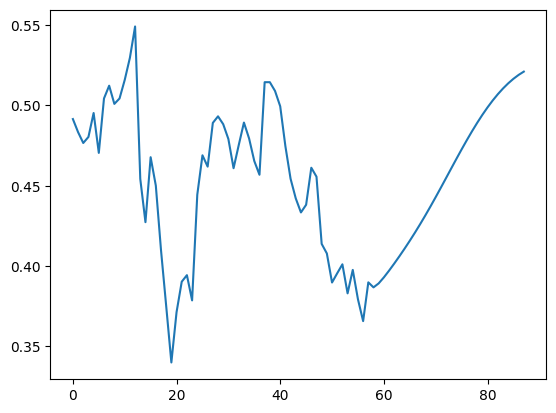

In [34]:
Day30_new=Index_data.tolist()
Day30_new.extend(lst_output)
plt.plot(Day30_new[1200:])

<IPython.core.display.Javascript object>

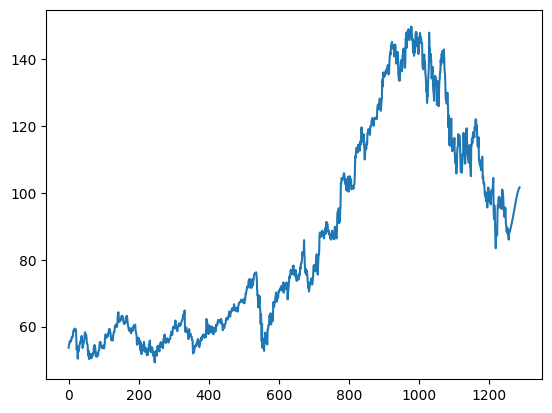

In [35]:
Day30_new=scaler.inverse_transform(Day30_new).tolist()
plt.plot(Day30_new)

In [36]:
# --------------------------------------------------------------------------------------------------------------------------------------------------------------